<h1>Sentence Emotion Detection using Multinomial Naive-Bayes
    
<h4>Created by : Giovanni Abel Christian<br>

## Process Flow Diagram

<img src="Diagram.jpg">

## Importing Libraries

In [63]:
# Importing the necessary libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.naive_bayes import MultinomialNB

# Explanation of libraries and functions used:
# - numpy: a library for manipulating n-dimensional arrays
# - pandas: a library for data manipulation and analysis
# - matplotlib.pyplot: a library for creating figures and plotting
# - re: a library for using regular expressions
# - train_test_split: a function to split the dataset into training and testing data
# - CountVectorizer: a function to convert documents into word tokens
# - StopWordRemoverFactory: a function for stopwords in the Indonesian language
# - StemmerFactory: a function for stemming in the Indonesian language
# - MultinomialNB: a classification function for Naive Bayes with discrete features


## Data Exploration

In [64]:
df = pd.read_excel("1000_fairytale.xlsx", names = ["sentence", "emotion"], header = None)  
# Mengimpor dataset dari file  "1000 data dongeng.xlsx" dalam bentuk dataframe, disimpan dalam variabel dongeng
# data set diberikan header yang bernama 'kalimat' dan 'emosi' menggunakan parameter names
df # menampilkan dataset dongeng 

,sentence,emotion
0,"Ketika kedua kalinya sang ibu menghampirinya, ...",marah
1,Pangeran Empang Kuala murka mendengar pinangan...,marah
2,Bujang Kelana akan menantang Pendekar Katung u...,marah
3,Pendekar Katung yang tidak terima dengan kekal...,marah
4,Ibunya sangat marah. ‘’ Dasar bodoh! Baju kesa...,marah
...,...,...
995,"Akan tetapi, ia dan rombongan terkejut sebab d...",terkejut
996,"Mendengar hal itu, Halimah sangat kaget dan te...",terkejut
997,Ketika aku memperhatikan domba-domba yang seda...,terkejut
998,Pada suatu hari beliau duduk di gua Hira dan t...,terkejut


In [65]:
df.info()  # view information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   emotion   1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


The dataset above represents a dataframe consisting of sentences and the emotions associated with those sentences. The dataset contains 1,000 observations and 2 columns.  
- Column **sentence**: Contains sentences in string format.  
- Column **emotion**: A categorical column representing the emotion reflected by each sentence.  

In [66]:
df['emotion'].value_counts()  # view the list of categories in the emotion variable along with their frequencies

emotion
senang      278
sedih       194
terkejut    183
marah       161
takut       136
jijik        48
Name: count, dtype: int64

<Axes: xlabel='emotion'>

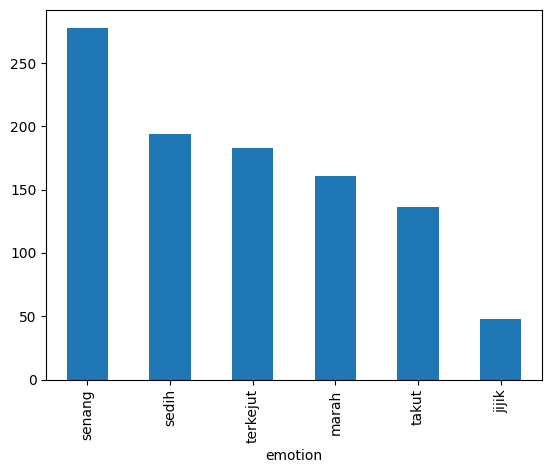

In [67]:
df['emotion'].value_counts().plot(kind='bar')  # Plot the distribution of categories in the emotion variable using a bar chart


Translation:
- senang : happy
- sedih : sad
- terkejut : surprised 
- marah : angry
- jijik : disgusted

The emotion variable consists of 6 emotions: happy, sad, surprised, angry, disgusted, and scared.  
The distribution of these variables varies, with the most frequent emotion being **happy** and the least frequent emotion being **disgusted**.

## Data Pre-processing

In the sentence variable, there are some digit characters that need to be cleaned. These digit characters are not needed in this case because they do not affect the emotions in the sentences and could potentially disrupt the input data for model training.

In [68]:
df.iloc[149, :].values  # displays an example of a sentence that contains digit characters

array(['Jatuhnya Jayakarta ke tangan Kompeni Belanda pada tahun 1619 membuat banyak ulama marah.',
       'marah'], dtype=object)

### Removing digits using regex

In [69]:
# Cleaning the sentence variable by removing numeric characters from the string
for i in df['sentence']:  # for each observation (string) in the sentence column of the dataframe
    newi = re.sub(r"[0-9]", "", i)  # create a new string by replacing numeric characters with an empty space
    df['sentence'] = df['sentence'].replace(i, newi)  # replace the old sentence with the new one

In [70]:
df.iloc[149, :].values  # displays the sentence with its digit characters removed

array(['Jatuhnya Jayakarta ke tangan Kompeni Belanda pada tahun  membuat banyak ulama marah.',
       'marah'], dtype=object)

## Stemming, extracting the root words

In [71]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
 
sentence = 'Jatuhnya Jayakarta ke tangan Kompeni Belanda pada tahun  membuat banyak ulama marah.'
root_words = stemmer.stem(sentence)

for i in df['sentence']:  # for each observation (string) in the sentence column of the dataframe
    newi = stemmer.stem(i)  # create a new word by stemming the sentence
    df['sentence'] = df['sentence'].replace(i, newi)  # replace the old sentence with the new stemmed one

In [72]:
df.iloc[149, :].values  # displays the sentence after stemming

array(['jatuh jayakarta ke tangan kompeni belanda pada tahun buat banyak ulama marah',
       'marah'], dtype=object)

## Defining Stopwords

In text processing, stopwords need to be defined. Stopwords are words that should be filtered out before text processing. They can become noise and thus need to be removed. Stopwords consist of irrelevant words from a language.  
In the Indonesian language, there are several stopwords that have already been defined. In this case, the stopwords are taken from the Sastrawi library.

In [73]:
# Importing Indonesian stop words
factory = StopWordRemoverFactory()  # storing the StopWordRemoverFactory function into the 'factory' variable
stopwords = factory.get_stop_words()  # retrieving stop words from the 'factory' variable and storing them in 'stopwords'
print(stopwords)  # displaying the Indonesian stop words

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

## Data Spliting

The dataset is split into training and test data. The training data is used for training the model, while the test data is used to evaluate the model's classification performance.  
In this case:  
- The predictor variable (X) is 'sentence'.  
- The target variable (y) is 'emotion'.


In [74]:
X = df.iloc[:, 0].values  # extracting the values of the predictor variable (sentence)
y = df.iloc[:, 1].values  # extracting the values of the target variable (emotion)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  # splitting the dataset using the train_test_split() function
# The dataset is split into 80% training data and 20% test data, set using the test_size parameter
# The dataset is divided into 4 parts:
# - X_train: predictor variable from the training data
# - X_test: predictor variable from the test data
# - y_train: target variable from the training data
# - y_test: target variable from the test data

## Feature Extraction

### Creating a Bag of Words and Removing Stop Words

In [75]:
# Creating bag of words using CountVectorizer()
cv=CountVectorizer(stop_words= stopwords)
train_dtm=cv.fit_transform(X_train)
test_dtm=cv.transform(X_test)

In [76]:
train_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6694 stored elements and shape (800, 1521)>

In [77]:
pd.DataFrame(train_dtm.toarray(), columns=cv.get_feature_names_out())

,abang,abdib,abdih,abdillah,abrahah,abrahahh,abu,acara,adik,adu,...,wayungyang,wedana,wilayah,wire,wujud,wungu,wush,yakin,yatim,yuyu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating TF-IDF and Removing Stop Words

In [78]:
# creating TF-IDF using TfidfVectorizer()
tf_cv=TfidfVectorizer(stop_words= stopwords)
train_dtm_tf=tf_cv.fit_transform(X_train)
test_dtm_tf=tf_cv.transform(X_test)

In [79]:
pd.DataFrame(train_dtm_tf.toarray(), columns=tf_cv.get_feature_names_out())

,abang,abdib,abdih,abdillah,abrahah,abrahahh,abu,acara,adik,adu,...,wayungyang,wedana,wilayah,wire,wujud,wungu,wush,yakin,yatim,yuyu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Naive Bayes Model Training

## Model #1 using Bag of Words

### Without Laplace Smoothing

In [80]:
#Model fitting
nb=MultinomialNB(alpha = 0)
nb=nb.fit(train_dtm,y_train)

/Users/giovanniabelchristian/program/venv/lib/python3.12/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


In [81]:
predicted=nb.predict(test_dtm)
score=nb.score(test_dtm,y_test)
score1=score*100.0
print('Accuracy of Naive Bayes :')
print(score1)

Accuracy of Naive Bayes :
33.5


In [82]:
#Display the classification report
print(metrics.classification_report(y_test,predicted,target_names=df['emotion'].unique().tolist()))

              precision    recall  f1-score   support

       marah       0.09      0.79      0.16        14
       jijik       0.56      0.28      0.38        32
       takut       0.80      0.27      0.41        44
      senang       0.81      0.38      0.52        45
       sedih       1.00      0.19      0.32        31
    terkejut       0.67      0.35      0.46        34

    accuracy                           0.34       200
   macro avg       0.65      0.38      0.37       200
weighted avg       0.72      0.34      0.41       200



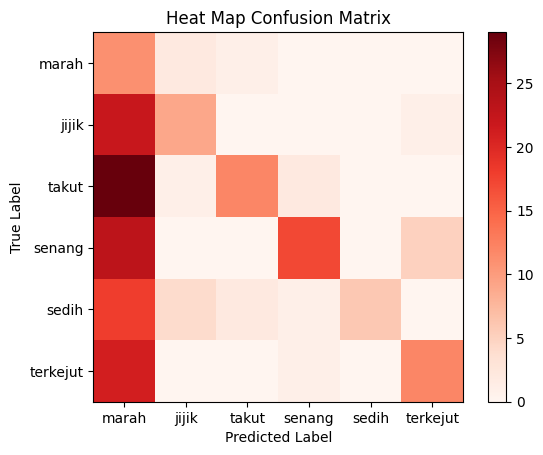

In [83]:
#Display the confusion matrix
conf_mat = confusion_matrix(y_test, predicted)
labels = df['emotion'].unique().tolist()

plt.figure()
plt.title("Heat Map Confusion Matrix")
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Reds)
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

### With Laplace Smoothing

In [84]:
#Model fitting
nb=MultinomialNB(alpha = 1.0)
nb=nb.fit(train_dtm,y_train)

In [85]:
predicted=nb.predict(test_dtm)
score=nb.score(test_dtm,y_test)
score2=score*100.0
print('Accuracy of Naive Bayes :')
print(score2)

Accuracy of Naive Bayes :
81.0


In [86]:
#Display the classification report
print(metrics.classification_report(y_test,predicted,target_names=df['emotion'].unique().tolist()))

              precision    recall  f1-score   support

       marah       1.00      0.21      0.35        14
       jijik       0.77      0.84      0.81        32
       takut       0.88      0.84      0.86        44
      senang       0.75      0.89      0.82        45
       sedih       0.87      0.84      0.85        31
    terkejut       0.78      0.85      0.82        34

    accuracy                           0.81       200
   macro avg       0.84      0.75      0.75       200
weighted avg       0.82      0.81      0.80       200



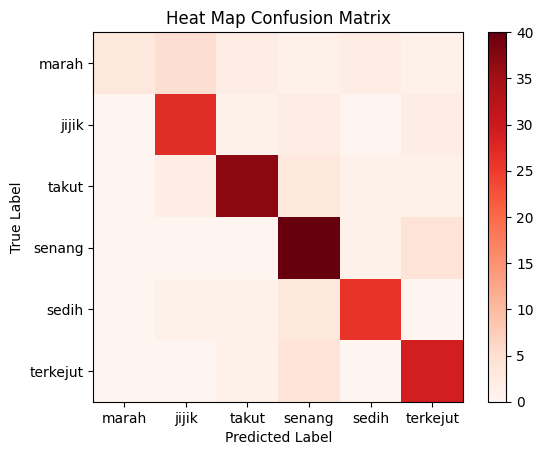

In [87]:
#Display the confusion matrix
conf_mat = confusion_matrix(y_test, predicted)
labels = df['emotion'].unique().tolist()

plt.figure()
plt.title("Heat Map Confusion Matrix")
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Reds)
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

### Result Analysis

The results of the Naive Bayes model using Bag-of-Words show the best accuracy of 74.5% with Laplace smoothing. Based on the confusion matrix heatmap, the results of both models are similar. The model is most reliable in classifying the emotion 'happy'(senang) in sentences. This is due to the imbalanced distribution of the target variable, meaning the frequency of 'happy'(senang) in the data is much higher than that of 'disgusted'(jijik). The model is unable to predict 'angry'(marah) at all because, in the test data, 'angry'(marah) only has 6 occurrences.  

The use of Laplace smoothing helped increase the accuracy by 11%, from 63.5%. In the Bag-of-Words word splitting using the CountVectorizer() function, the resulting values are discrete or binary. Therefore, when calculating the Naive Bayes probability: P(target|word not present) = 0, it would 'cancel out' the probability calculation and result in 0. Laplace smoothing was applied to prevent the target probability calculation from becoming 0 and to improve accuracy. This was proven by the 11% increase in model accuracy.


## Model #2 using TF-IDF

### Without Laplace Smoothing

In [88]:
nb=MultinomialNB(alpha = 0)
nb.fit(train_dtm_tf,y_train)

/Users/giovanniabelchristian/program/venv/lib/python3.12/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


MultinomialNB(alpha=0)

In [89]:
prdicted=nb.predict(test_dtm_tf)
print("Accuracy of Naive Bayes Algo:")
score3=100.0* nb.score(test_dtm_tf,y_test)
print(score3)

Accuracy of Naive Bayes Algo:
33.5


In [90]:
#Display the classification report
from sklearn import metrics
print(metrics.classification_report(y_test,prdicted,target_names=df['emotion'].unique().tolist(), zero_division = 1))

              precision    recall  f1-score   support

       marah       0.09      0.79      0.16        14
       jijik       0.60      0.28      0.38        32
       takut       0.75      0.27      0.40        44
      senang       0.81      0.38      0.52        45
       sedih       1.00      0.19      0.32        31
    terkejut       0.67      0.35      0.46        34

    accuracy                           0.34       200
   macro avg       0.65      0.38      0.37       200
weighted avg       0.72      0.34      0.41       200



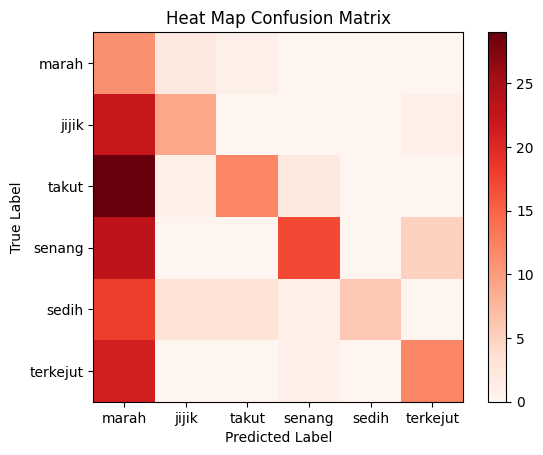

In [91]:
#Display the confusion matrix
conf_mat = confusion_matrix(y_test, prdicted)
labels = df['emotion'].unique().tolist()

plt.figure()
plt.title("Heat Map Confusion Matrix")
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Reds)
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

### With Laplace Smoothing

In [92]:
nb=MultinomialNB(alpha = 1)
nb.fit(train_dtm_tf,y_train)

MultinomialNB(alpha=1)

In [93]:
prdicted=nb.predict(test_dtm_tf)
print("Accuracy of Naive Bayes Algo:")
score4=100.0* nb.score(test_dtm_tf,y_test)
print(score)

Accuracy of Naive Bayes Algo:
0.81


In [94]:
#Display the classification report
from sklearn import metrics
print(metrics.classification_report(y_test,prdicted,target_names=df['emotion'].unique().tolist(), zero_division = 1))

              precision    recall  f1-score   support

       marah       1.00      0.00      0.00        14
       jijik       1.00      0.41      0.58        32
       takut       0.85      0.64      0.73        44
      senang       0.37      0.93      0.53        45
       sedih       0.90      0.29      0.44        31
    terkejut       0.77      0.71      0.74        34

    accuracy                           0.58       200
   macro avg       0.82      0.50      0.50       200
weighted avg       0.77      0.58      0.57       200



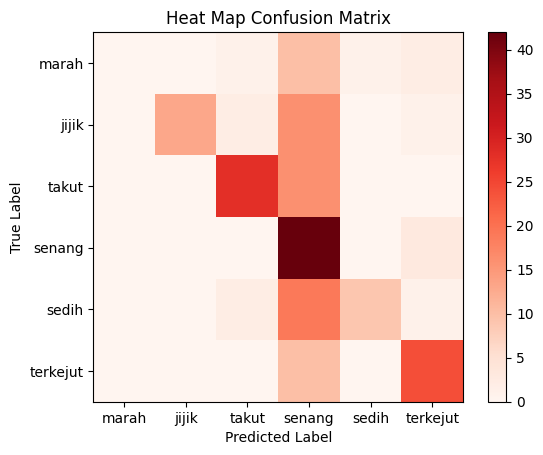

In [95]:
#Display the confusion matrix
conf_mat = confusion_matrix(y_test, prdicted)
labels = df['emotion'].unique().tolist()

plt.figure()
plt.title("Heat Map Confusion Matrix")
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Reds)
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

### Result Analysis

The results of the Naive Bayes model using TF-IDF show the best accuracy of 64% with Laplace smoothing. This is not much different from the Naive Bayes model, where 'happy'(senang) is the most accurate emotion to classify due to the high frequency of the 'happy'(senang) category in the dataset. Compared to the model using Bag-of-Words, which did not classify 'angry'(marah) correctly at all, the TF-IDF model was able to classify 'angry'(marah) with 100% accuracy according to the classification report.  

The use of Laplace smoothing helped increase the accuracy by 10%, from 54%. The TF-IDF distribution calculated using the tfidfVectorizer() function results in continuous values between 0 and 1. TF-IDF evaluates the importance of a word in a document. However, many TF-IDF values still result in 0. Therefore, Laplace smoothing is still necessary to prevent the target probability calculation from becoming 0 and to improve accuracy.


### Model Comparison

In [101]:
data = {'model1 no laplace': str(score1)+'%', 'model1 laplace':str(score2)+'%' ,'model2 no laplace':str(score3)+'%', 'model2 laplace':str(round(score4,1))+'%' }  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index = ['accuracy'])  
  
# print the data  
print(df) 

         model1 no laplace model1 laplace model2 no laplace model2 laplace
accuracy             33.5%          81.0%             33.5%          58.0%


Based on the results of the text classification work, the following conclusions can be made:  
- Overall, the Naive Bayes model using Bag-of-Words (model 1) achieves the highest accuracy with a rate of 81.0%.  
- Laplace smoothing helps improve accuracy by 25-47%.  
- The data distribution is uneven for each target classification frequency, which makes the classification of certain targets more accurate than others.  
- The feature extraction process aids in the model training process.

References:
- Regex Filtering: Malik, Usman. “Using Regex for Text Manipulation in Python.” Stack Abuse, Accessed on April 16 2021, https://stackabuse.com/using-regex-for-text-manipulation-in-python/
- Naive Bayes model training dan Classification Report: Singh, Shubham. “INTRODUCTION TO TEXT CLASSIFICATION AND NAIVE BAYES CLASSIFIER.” Kaggle, May 21 2020, https://www.kaggle.com/shub99/text-classification-and-naive-bayes-classifier
- Heatmap Confusion Matrix: Lee, Jay. “Document Classification using Naive Bayes Method.” Kaggle, February 7 2019, https://www.kaggle.com/jayaos/document-classification-using-naive-bayes-method
- Bag of words dan TF-IDF: Yordanov, Ventsislav. "Introduction to Natural Language Processing for Text" medium,  November 17 2018, https://towardsdatascience.com/introduction-to-natural-language-processing-for-text-df845750fb63
- Stop words Bahasa Indonesia: Yulio, Anggi. "Stopword Removal Bahasa Indonesia dengan Python Sastrawi" devtrik,  June 3 2017, https://devtrik.com/python/stopword-removal-bahasa-indonesia-python-sastrawi/
- Stemming Bahasa Indonesia: Yulio, Anggi. "Steeming Bahasa Indonesia dengan Python Sastrawi" devtrik,  May 22 2017,https://devtrik.com/python/steeming-bahasa-indonesia-python-sastrawi/